In [22]:
from tqdm import tqdm

from workflow.model.genome import Genome
from workflow.gunc.aggregate_max_css_level_merged import AggregateMaxCssLevelMerged
from workflow.model.gunc_model import GuncRefDb
from collections import defaultdict
import matplotlib.pyplot as plt



In [2]:
DF_CSS = AggregateMaxCssLevelMerged().output().read_cached()
DF_CSS.head()

,n_genes_called,n_genes_mapped,n_contigs,taxonomic_level,proportion_genes_retained_in_major_clades,genes_retained_index,clade_separation_score,contamination_portion,n_effective_surplus_clades,mean_hit_identity,reference_representation_score,pass.GUNC,source
gid,,,,,,,,,,,,,
GCA_000143435.1,2189,2110,4,genus,0.89,0.86,0.55,0.03,0.06,0.95,0.82,False,gtdb
GCA_000153745.1,2202,2165,2,family,0.92,0.90,0.49,0.06,0.12,0.67,0.61,False,progenomes
GCA_000155005.1,6879,6313,84,genus,0.87,0.79,0.79,0.10,0.22,0.97,0.77,False,gtdb
GCA_000161815.1,4499,4335,8,genus,0.80,0.77,0.50,0.19,0.50,0.95,0.74,False,progenomes
GCA_000166735.2,3414,3247,793,genus,0.94,0.90,0.57,0.02,0.05,0.93,0.83,False,progenomes


In [34]:
MAX_CONGRUENCE = [30, 50, 90]
MIN_PCT_REMOVED = [0, 25, 50, 75, 90]

In [37]:


def get_data():

    bw_markers = defaultdict(list)
    bw_pct_removed = defaultdict(list)

    for n, row in tqdm(enumerate(DF_CSS.itertuples()), total=len(DF_CSS)):
        gid = row.Index
        max_css = row.taxonomic_level
        source = GuncRefDb.GTDB if row.source == 'gtdb' else GuncRefDb.PRO


        g = Genome(gid)

        for congruence in MAX_CONGRUENCE:
            for min_pct in MIN_PCT_REMOVED:

                if min_pct == 0:
                    pct_removed = 0
                    marker_hits = g.get_marker_hits()
                    n_unq = len(marker_hits['unq']) + len(marker_hits['muq'])

                else:
                    contigs_removed, pct_removed = g.get_gunc_contigs_where_removed_equals_x_pct_genome_removed(
                        pct=min_pct, max_congruence=congruence, max_css=max_css, source=source
                    )

                    # y = g.get_random_contigs_where_removed_equals_x_pct_genome_removed(pct=50)
                    #
                    marker_hits = g.get_marker_hits(omit_contigs=frozenset(contigs_removed))
                    n_unq = len(marker_hits['unq']) + len(marker_hits['muq'])

                # print(congruence, min_pct, gid,n_unq, pct_removed)
                bw_markers[(congruence, min_pct)].append(n_unq)
                bw_pct_removed[(congruence, min_pct)].append(pct_removed)

        if n > 50:
            break

    return bw_markers, bw_pct_removed

BW_MARKERS, BW_PCT_REMOVED = get_data()


  0%|          | 51/35723 [01:01<11:52:07,  1.20s/it]


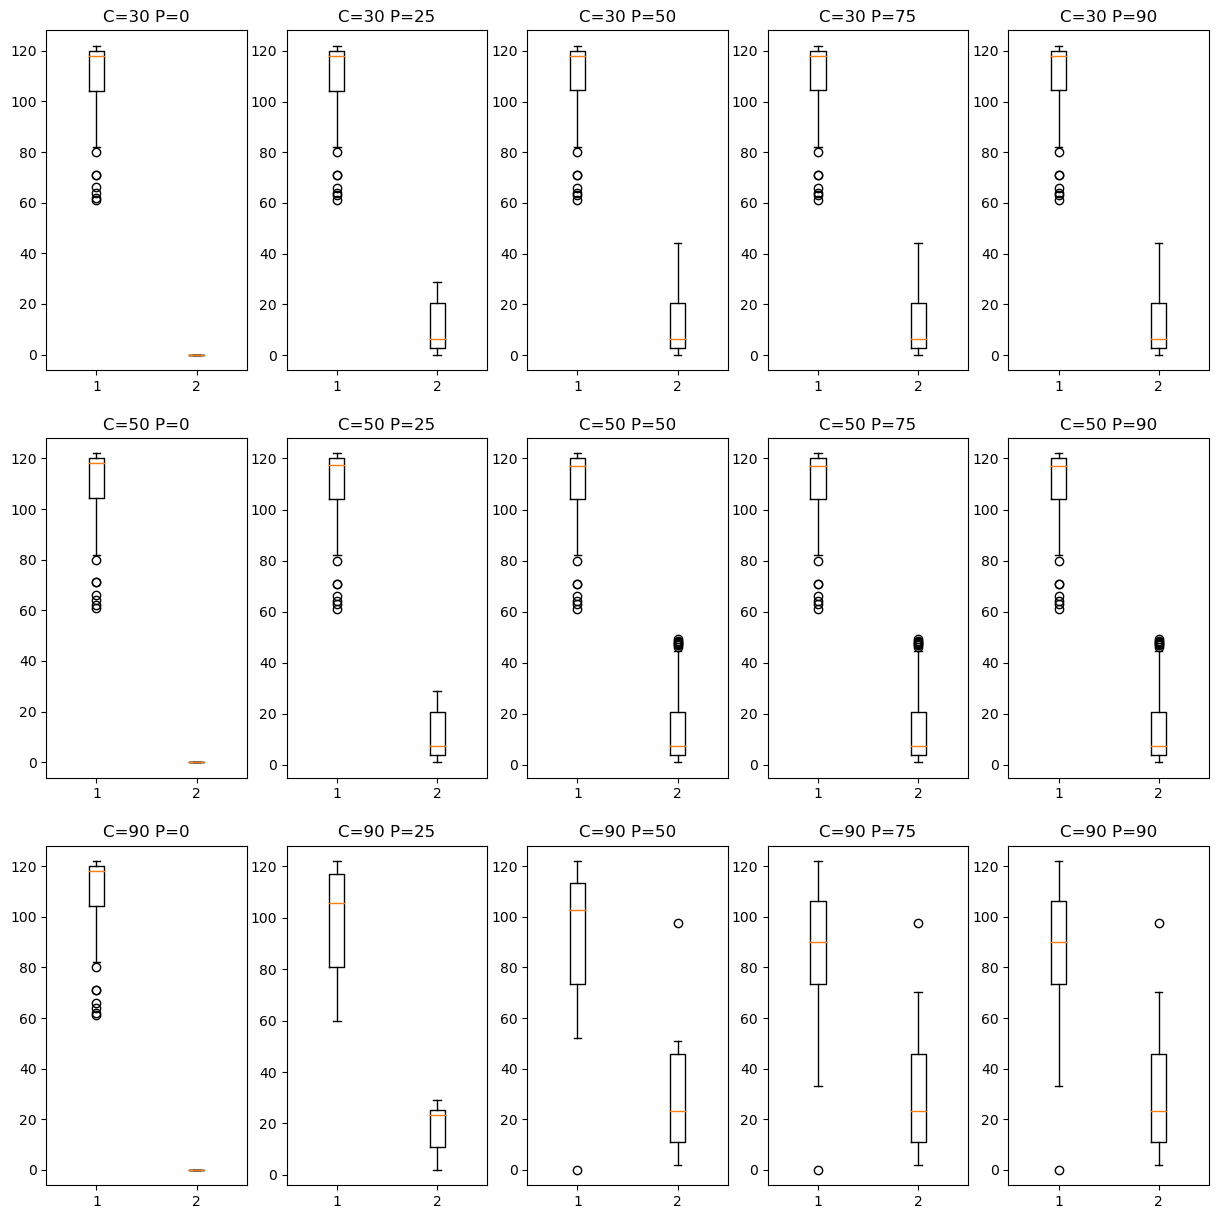

In [38]:
def plot_data():

    fig, axes = plt.subplots(nrows=len(MAX_CONGRUENCE), ncols=len(MIN_PCT_REMOVED), figsize=(15, 15))

    for i, max_congruence in enumerate(MAX_CONGRUENCE):
        for j, min_pct in enumerate(MIN_PCT_REMOVED):

            ax = axes[i, j]
            n_unq = BW_MARKERS[(max_congruence, min_pct)]
            pct_removed = BW_PCT_REMOVED[(max_congruence, min_pct)]

            ax.set_title(f'C={max_congruence} P={min_pct}')
            ax.boxplot([n_unq, pct_removed])

    plt.show()





    return

plot_data()